# Notebook to perform sentiment analysis and topic modelling for Mentaiya. Please read the text below.

# Important Information
This notebook was ran on Google Colab Pro (not drive mounted). To replicate this notebook:

<ol>
    <li> Import notebook to colab</li>
    <li> Import Mentaiya's combined reviews dataset. Dataset can be found in repository: <b>/data/competitors/mentaiya_reviews_combined.csv</b></li>
    <li> Change runtime to GPU</li>
    <li> Install dependencies (run code block below. You may be asked to restart runtime after installing. IF you do so, please ensure runtime is GPU again.</li>
</ol>

# Expected directory
In google colab, your directory should now consist of one folder and two files:
<ol>
    <li>sample_data folder: Default folder from Google Colab</li>
    <li>mentaiya_combined_reviews.csv: Dataset comprising Mentaiya's reviews from all data sources</li>
</ol>

# Install and import dependencies

In [1]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import string
import re
import string

from PIL import Image
import os
from os import path
import csv

from bertopic import BERTopic
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

ModuleNotFoundError: No module named 'wordcloud'

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Helper Functions

In [5]:
# Function to create a dictionary with word counts from dataframe 
def count_words_from_dataframe(df):
    result_dict = {}
    # iterate rows of dataframe 
    for index, row in df.iterrows():
        text = row["cleaned_reviews"]
        
        # this will split a sentence into words 
        tokens = text.split()
        
        # iterate each word 
        for i in range(0, len(tokens)):
            token = tokens[i].rstrip()
            token=token.strip()
            try:
                result_dict[token] += 1
            except KeyError:
                result_dict[token] = 1
                    
    return result_dict

In [6]:
# Function to create Word Cloud
def makeImage(termDict):
    
    wc = WordCloud(max_font_size=150, width=1280, height=720, background_color="white")    

    # generate word cloud using frequencies!
    wc.generate_from_frequencies(termDict)
    
    # show the figure
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show() 

In [7]:
def clean_text_round1(text):
    '''Make text lowercase, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\n','',text) #remove \n which act as extra lines in reviews
    return text

In [8]:
# Variable 'stop' set to list of english stopwords from nltk library
stop = stopwords.words('english')
stop.extend(['ngl','lol','thats','theyre','tbh','idk','rall','theres','youre','yall','dont','aint','ive','arent','havent','wtf','thatll','omg','theyd','woah','fucking','wouldve','shit','wouldve','werent','repost','deleted','heres','wouldnt','fuck','cant','haha'])

def clean_text_round2(text):
    return ' '.join([word for word in text.split() if word not in (stop)])

In [9]:
def read_word_count_file(file_path):
    with open(file_path, mode='r', encoding="latin1") as infile:
        reader = csv.reader(infile)
        counts = {}
        for row in reader:
            if len(row) >0 :
                counts[row[0]] = float(row[1])
        return counts

# Get Data

In [43]:
comments_df = pd.read_csv("mentaiya_reviews_combined.csv", encoding="unicode-escape", header=None)
comments_df = comments_df.rename(columns={0: "Reviews"})

In [44]:
comments_df.head()

,Reviews
0,"Very hearty amounts, even despite me asking fo..."
1,I absolutely loved the food here! I had the sa...
2,Hands down the best mentaiko place! The spicy ...
3,I ordered the salmon and chicken mentai-ya and...
4,Ordered the spicy salmon mentai don. A tad too...


# Data Cleaning

In [45]:
comments_df["clean_text_1"]=comments_df['Reviews'].apply(clean_text_round1)
comments_df

,Reviews,clean_text_1
0,"Very hearty amounts, even despite me asking fo...",very hearty amounts even despite me asking for...
1,I absolutely loved the food here! I had the sa...,i absolutely loved the food here i had the sal...
2,Hands down the best mentaiko place! The spicy ...,hands down the best mentaiko place the spicy s...
3,I ordered the salmon and chicken mentai-ya and...,i ordered the salmon and chicken mentaiya and ...
4,Ordered the spicy salmon mentai don. A tad too...,ordered the spicy salmon mentai don a tad too ...
...,...,...
349,Affordable Japanese food in the West! Each sli...,affordable japanese food in the west each slic...
350,Just came back from an extremely good meal at ...,just came back from an extremely good meal at ...
351,Salmon and garlic fried rice ï¿½ ï¿½ overall f...,salmon and garlic fried rice ï¿½ ï¿½ overall f...
352,Nice food..cozy place ....reasonable price and...,nice foodcozy place reasonable price and good ...


In [46]:
comments_df['clean_text_2']=comments_df['clean_text_1'].apply(clean_text_round2)
comments_df

,Reviews,clean_text_1,clean_text_2
0,"Very hearty amounts, even despite me asking fo...",very hearty amounts even despite me asking for...,hearty amounts even despite asking less rice m...
1,I absolutely loved the food here! I had the sa...,i absolutely loved the food here i had the sal...,absolutely loved food salmon mentaiko rice alo...
2,Hands down the best mentaiko place! The spicy ...,hands down the best mentaiko place the spicy s...,hands best mentaiko place spicy salmon packs p...
3,I ordered the salmon and chicken mentai-ya and...,i ordered the salmon and chicken mentaiya and ...,ordered salmon chicken mentaiya absolutely del...
4,Ordered the spicy salmon mentai don. A tad too...,ordered the spicy salmon mentai don a tad too ...,ordered spicy salmon mentai tad spicy taste go...
...,...,...,...
349,Affordable Japanese food in the West! Each sli...,affordable japanese food in the west each slic...,affordable japanese food west slice sashimi ra...
350,Just came back from an extremely good meal at ...,just came back from an extremely good meal at ...,came back extremely good meal tenryu family fo...
351,Salmon and garlic fried rice ï¿½ ï¿½ overall f...,salmon and garlic fried rice ï¿½ ï¿½ overall f...,salmon garlic fried rice ï¿½ ï¿½ overall food ...
352,Nice food..cozy place ....reasonable price and...,nice foodcozy place reasonable price and good ...,nice foodcozy place reasonable price good service


In [47]:
cleaned_df = pd.DataFrame()
cleaned_df["cleaned_reviews"] = comments_df["clean_text_2"]
cleaned_df.head()

,cleaned_reviews
0,hearty amounts even despite asking less rice m...
1,absolutely loved food salmon mentaiko rice alo...
2,hands best mentaiko place spicy salmon packs p...
3,ordered salmon chicken mentaiya absolutely del...
4,ordered spicy salmon mentai tad spicy taste go...


In [48]:
# Get word frequency
result = count_words_from_dataframe(cleaned_df)

# sorting the words based on their frequency
sorted_dic = {k: v for k, v in sorted(result.items(), key=lambda item: item[1])}

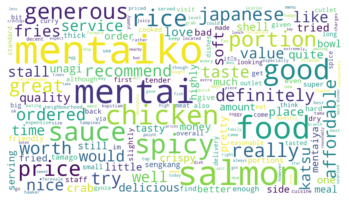

In [49]:
makeImage(sorted_dic)

In [50]:
reviews_list = cleaned_df['cleaned_reviews'].tolist()

In [51]:
reviews_list[:5]

['hearty amounts even despite asking less rice mentaiko amounts generous filled umamisalmon slice thick delicious little bigger expected mentaiko fries didn\x92t disappoint toooverall value money probably need work abit making rice w sauce tasty would perfect',
 'absolutely loved food salmon mentaiko rice alongside fries great lunch portions particularly large considering affordable price would go',
 'hands best mentaiko place spicy salmon packs punch \x97 making shiok meal pair cold drink however fried chicken cutlet mentaiko stole show juicy crispy went well mentaiko without feeling greasy jelak would suggest getting mentaiko fries honestly couldn\x92t get enough',
 'ordered salmon chicken mentaiya absolutely delicious chicken crispy salmon fresh portion generous yes rice nice soft come back eat someday although location bit way',
 'ordered spicy salmon mentai tad spicy taste good little plain good comes seaweed pickled ginger like serve japan isit much \x93char\x94 taste although to

# Sentiment Analysis with HuggingFace

In [52]:
# Load the "sentiment prediction" model.
classifier = pipeline("sentiment-analysis", device = 0)

# input: sentence, output: sentiment label and score
sentiment_list= classifier(reviews_list)
zipped_list=[]
for i in range(len(reviews_list)):
    zipped=[reviews_list[i],sentiment_list[i]['label'],sentiment_list[i]['score']]
    zipped_list.append(zipped)

df_sentiment=pd.DataFrame(zipped_list, columns=['review','sentiment','sentiment score'])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [53]:
df_sentiment.head()

,review,sentiment,sentiment score
0,hearty amounts even despite asking less rice m...,POSITIVE,0.996460
1,absolutely loved food salmon mentaiko rice alo...,POSITIVE,0.999306
2,hands best mentaiko place spicy salmon packs p...,POSITIVE,0.974823
3,ordered salmon chicken mentaiya absolutely del...,POSITIVE,0.998068
4,ordered spicy salmon mentai tad spicy taste go...,POSITIVE,0.504674


In [54]:
positive_review = df_sentiment[df_sentiment['sentiment'] == 'POSITIVE']
positive_review.head()

,review,sentiment,sentiment score
0,hearty amounts even despite asking less rice m...,POSITIVE,0.996460
1,absolutely loved food salmon mentaiko rice alo...,POSITIVE,0.999306
2,hands best mentaiko place spicy salmon packs p...,POSITIVE,0.974823
3,ordered salmon chicken mentaiya absolutely del...,POSITIVE,0.998068
4,ordered spicy salmon mentai tad spicy taste go...,POSITIVE,0.504674


In [22]:
positive_review['sentiment score'].mean()

0.9709700222422437

In [23]:
negative_review = df_sentiment[df_sentiment['sentiment'] == 'NEGATIVE']
negative_review.head()

,review,sentiment,sentiment score
5,hard undercooked ricethe standard seem constan...,NEGATIVE,0.995880
6,ordered gyoza soft shell crab chicken salmon m...,NEGATIVE,0.998385
8,ordered mentaiko salmon mentaiko amount genero...,NEGATIVE,0.984576
11,decided try mentaiya since nearby ordered ment...,NEGATIVE,0.859265
13,came many times affordable pricing place new c...,NEGATIVE,0.955938


In [24]:
negative_review['sentiment score'].mean()

0.9448427745589504

In [25]:
df_sentiment['sentiment'].value_counts()

POSITIVE    246
NEGATIVE    108
Name: sentiment, dtype: int64

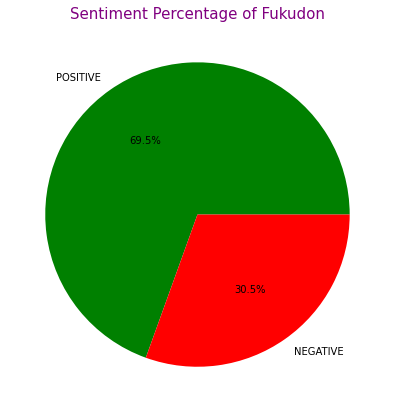

<Figure size 432x288 with 0 Axes>

In [26]:
df = df_sentiment['sentiment'].value_counts()
#pie chart
df.dropna(inplace = True)
labels =df.index
colors = ['green','red']
explode = [0,0]
sizes = df.values

# visual
plt.figure(figsize = (7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Sentiment Percentage of Mentaiya",color = 'purple',fontsize = 15)
fig1 = plt.gcf()
plt.show()
plt.draw()

In [41]:
positive_review_list=positive_review['review'].tolist()
negative_review_list=negative_review['review'].tolist()

# Topic Modelling

In [42]:
positive_review_list[0]

'hearty amounts even despite asking less rice mentaiko amounts generous filled umamisalmon slice thick delicious little bigger expected mentaiko fries didn\x92t disappoint toooverall value money probably need work abit making rice w sauce tasty would perfect'

## For Positive Reviews

In [55]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(positive_review_list)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2022-04-11 12:27:28,396 - BERTopic - Transformed documents to Embeddings
2022-04-11 12:27:31,409 - BERTopic - Reduced dimensionality with UMAP
2022-04-11 12:27:31,432 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [56]:
freq = topic_model.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,0,170,0_mentaiko_salmon_mentai_spicy
1,1,53,1_food_price_good_nice
2,2,13,2_crab_shell_soft_mentaiko
3,-1,10,-1_tampines_food_katsu_eaten


In [57]:
topic_model.visualize_barchart()

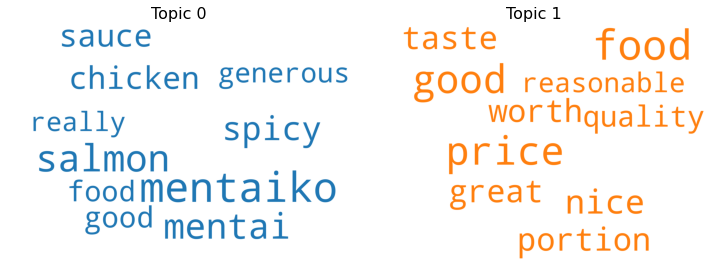

<Figure size 432x288 with 0 Axes>

In [58]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

tps = topic_model.get_topics()

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(tps[i])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
fig2 = plt.gcf()
plt.show()
plt.draw()

In [59]:
topic_model.visualize_heatmap(width=1000, height=1000)

In [60]:
# Visualize Topic Probabilities
topic_model.visualize_distribution(probs[1], min_probability=0.015)

In [61]:
topic_model.get_topics()

{-1: [('tampines', 0.12750575689142224),
  ('food', 0.11373267175768736),
  ('katsu', 0.10969292036532648),
  ('eaten', 0.10473124490659302),
  ('chicken', 0.0736810141403596),
  ('always', 0.06982082993772869),
  ('dish', 0.06746502584647236),
  ('definitely', 0.06630967088242833),
  ('week', 0.06375287844571112),
  ('side', 0.06375287844571112)],
 0: [('mentaiko', 0.09110970284829809),
  ('salmon', 0.07381612627296838),
  ('mentai', 0.06556575901115876),
  ('spicy', 0.05740069984668516),
  ('sauce', 0.050857440657870984),
  ('chicken', 0.0504048533960485),
  ('good', 0.04437942557966135),
  ('food', 0.042272906834491426),
  ('generous', 0.039407961130573564),
  ('really', 0.036844688079067336)],
 1: [('food', 0.1329070021002074),
  ('price', 0.12042459464640601),
  ('good', 0.11927394059183263),
  ('nice', 0.08330964897044169),
  ('taste', 0.07787775765640277),
  ('portion', 0.07687359558492655),
  ('great', 0.07578815324322578),
  ('worth', 0.07497868407339751),
  ('quality', 0.0639

## Negative Reviews

In [62]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(negative_review_list)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2022-04-11 12:27:47,173 - BERTopic - Transformed documents to Embeddings
2022-04-11 12:27:51,675 - BERTopic - Reduced dimensionality with UMAP
2022-04-11 12:27:51,692 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [63]:
freq = topic_model.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,0,59,0_mentai_mentaiko_salmon_rice
1,-1,25,-1_food_curry_one_tried
2,1,24,1_food_service_portion_bad


In [64]:
topic_model.visualize_barchart()

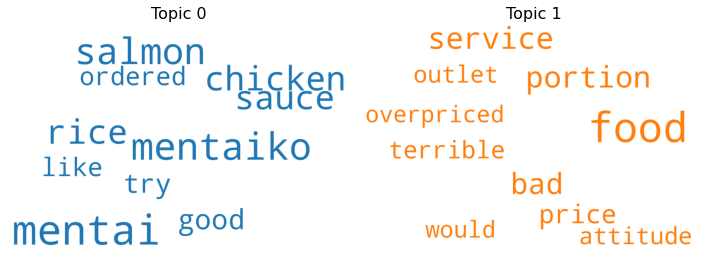

<Figure size 432x288 with 0 Axes>

In [65]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

tps = topic_model.get_topics()

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(tps[i])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
fig2 = plt.gcf()
plt.show()
plt.draw()

In [66]:
# Visualize Topic Probabilities
topic_model.visualize_distribution(probs[1], min_probability=0.015)